# Modeling

In [2]:
# Imports
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

In [3]:
# Loading in the cleaned and normalized data
df = pd.read_csv('data/reddit_post_cleaned_normalized.csv')

In [4]:
df['body'] = df['body'].fillna('')

In [5]:
# Initializing TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Combining title and body text
df['combined_text'] = df['title'] + ' ' + df['body']

# Applying TF-IDF transformation
X = tfidf_vectorizer.fit_transform(df['combined_text'])

# Checking shape of the transformed matrix
print(f"TF-IDF Matrix Shape: {X.shape}")

TF-IDF Matrix Shape: (2692, 73457)


In [6]:
from sklearn.model_selection import train_test_split

# Defining the target variable, encoding subreddits
y = df['subreddit'].map({'askscience': 0, 'explainlikeimfive': 1})

# Splitting the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shape of the splits
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (2153, 73457)
Test set size: (539, 73457)


## Logistic Regression Model

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initializing the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Training the model
lr_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluating the model
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
Accuracy: 0.7179962894248608
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       279
           1       0.70      0.73      0.71       260

    accuracy                           0.72       539
   macro avg       0.72      0.72      0.72       539
weighted avg       0.72      0.72      0.72       539



## Random Forest Model

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initializing the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
Accuracy: 0.6901669758812616
              precision    recall  f1-score   support

           0       0.81      0.53      0.64       279
           1       0.63      0.87      0.73       260

    accuracy                           0.69       539
   macro avg       0.72      0.70      0.68       539
weighted avg       0.72      0.69      0.68       539



The model correctly identifies 87% of actual ELI5 posts. This aligns well with your goal of ensuring that AskScience users get flagged if their post is actually ELI5. Some AskScience posts are mistakenly classified as ELI5 and that makes sense given that there might be new users who are unaware that there is an ELIF subreddit and instead posting in askscience.


Our Random Forest (RF) model is a better choice than Logistic Regression (LR) because it achieves significantly higher recall for r/ExplainLikeImFive (ELI5) posts, which is our priority. While LR has a slightly higher overall accuracy (0.72 vs. 0.69), RF achieves a recall of 0.87 for ELI5, compared to only 0.73 for LR, meaning it correctly identifies more ELI5 posts. Since we want to ensure that users posting ELI5-style questions are correctly recommended to r/AskScience when necessary, recall is the more important metric. Additionally, RF is better suited for text classification because it handles non-linear relationships and complex feature interactions, unlike LR, which assumes a linear decision boundary. RF's ability to identify important features dynamically also makes it more effective at dealing with the high dimensional and sparse nature of TF-IDF vectorized text. lastly, RF is more robust and less prone to overfitting than LR. Given our goal of accurately distinguishing between scientific and simplified explanations, Random Forest is the superior model for this classification task.

## Feature Importance

In [12]:
# Getting feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()
importance_df = pd.DataFrame({'Word': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(20))

           Word  Importance
72343     would    0.006721
19709     earth    0.006362
49397  possible    0.004564
60341    specie    0.003856
68977   vaccine    0.003750
69541     virus    0.003331
27394       get    0.003288
14603     could    0.003216
15022   covid19    0.003137
58448     since    0.002915
72008      work    0.002863
22472      ever    0.002665
24575      feel    0.002611
46015  organism    0.002583
22057       etc    0.002544
37293      like    0.002538
48552    planet    0.002225
37127     light    0.002106
45401       one    0.002063
31702     human    0.002060


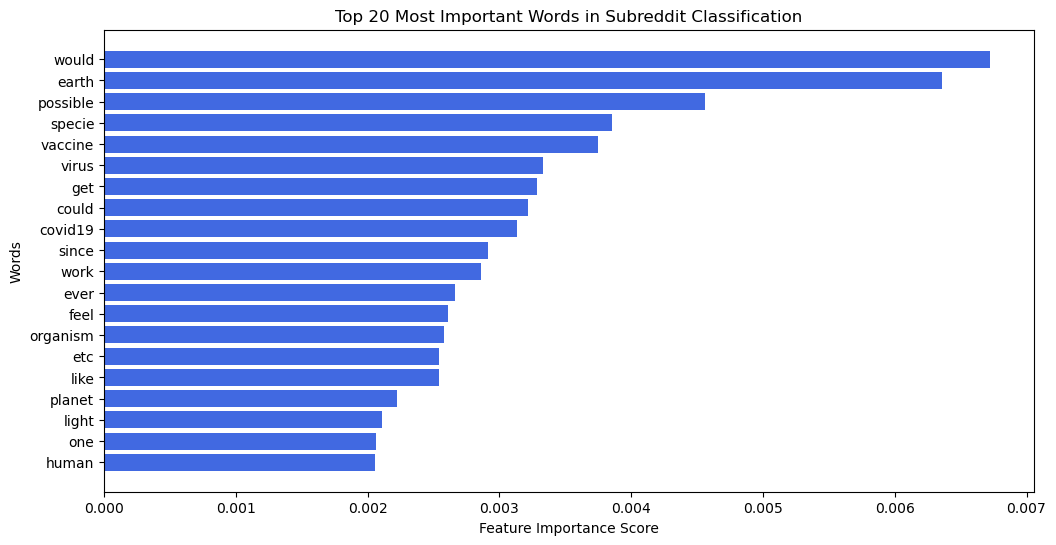

In [13]:
# Plotting the above
plt.figure(figsize=(12,6))
plt.barh(importance_df['Word'][:20], importance_df['Importance'][:20], color='royalblue')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance Score")
plt.ylabel("Words")
plt.title("Top 20 Most Important Words in Subreddit Classification")
plt.savefig('images/most_important_by_classifier.png', dpi=300)
plt.show()

## Hyperparameter Tuning

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [50, 75, 100],
    'min_samples_split': [100, 200]
}

# Initializing GridSearchCV, optimizing for recall of ELI5
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Training the model with GridSearchCV
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall Score: {grid_search.best_score_}")

# Using the best model for predictions
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluating the tuned model
print("Tuned Random Forest Performance:")
print(classification_report(y_test, y_pred_best_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 50, 'min_samples_split': 200, 'n_estimators': 200}
Best Recall Score: 0.6953132250580046
Tuned Random Forest Performance:
              precision    recall  f1-score   support

           0       0.79      0.59      0.68       279
           1       0.66      0.83      0.73       260

    accuracy                           0.71       539
   macro avg       0.72      0.71      0.71       539
weighted avg       0.73      0.71      0.71       539



Hyperparameter tuning did not seem to improve our results. It could be that we need to try more parameters. However, given the amount of features we have included in our model it is quite time consuming and so we will have to optimize the model in the future.

#### Input your own text to test our RF model

In [27]:
# Initializing the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [29]:
def predict_subreddit(input_text, model, vectorizer):
    input_text_cleaned = preprocess_text(input_text)
    
    # Applying TF-IDF transformation
    input_vectorized = vectorizer.transform([input_text_cleaned])
    
    # Predicting the subreddit
    prediction = model.predict(input_vectorized)
    
    # Mapping the prediction back to subreddit name
    subreddit_pred = 'askscience' if prediction == 0 else 'explainlikeimfive'
    
    return subreddit_pred
# Input question
input_question = "Calculate the energy levels and wavelengths of light emitted or absorbed by a hydrogen atom, using the Bohr model or the Schrödinger equation."
predicted_subreddit = predict_subreddit(input_question, rf_model, tfidf_vectorizer)
print(f"The question belongs to subreddit: {predicted_subreddit}")

The question belongs to subreddit: askscience
